In this project, first we apply the Kmeans and PCA to see how many clusters we have for the entire features. The optimum number of clusters are determined through elbow and silhouette. Then, PCA is used to visulaize the optimum number of clusters of Kmeans. Then, the two most important features are identified through PCA and statistical score. Then, Kmeans is used with the Z score algorithim to detect the anoamly detection. Then, DBSCAN and HDBSCAN are used to detemine the anomaly detections.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
# Importing libraries from sklearn 

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import numpy as np # This library allows to easily carry out simple and complex mathematical operations.
import matplotlib.pyplot as plt #Allows us to plot data, create graphs and visualize data. Perfect for your Powerpoint slides ;)
import sklearn #The one and only. This amazing library holds all the secrets. Containing powerful algorithms packed in a single line of code, this is where the magic will happen.
import sklearn.model_selection # more of sklearn. It is a big library, but trust me it is worth it.
import sklearn.preprocessing 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score,mean_absolute_error,mean_squared_error,precision_score,recall_score, accuracy_score,f1_score
from sklearn.utils import shuffle
import pandas as pd
from pandas.plotting import radviz


import random # Allows us to call random numbers, occasionally very useful.
import pprint#Allows us to neatly display text
from collections import OrderedDict


#Unsupervised Learning
from sklearn.neighbors import NearestNeighbors,LocalOutlierFactor
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy import stats
from scipy.stats import norm
from sklearn.cluster import DBSCAN
from sklearn.model_selection import RandomizedSearchCV
import hdbscan
from sklearn.metrics import make_scorer
import logging
logging.captureWarnings(True)
sns.set()
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

# 1) Data Description
From the info() above, it is clear that the data is clean and there are no missing data here. Hence we do not have to perform any data cleansing and we can jump straight into modeling the algorithm

In [2]:
white_wine = pd.read_csv("wine-white.csv")
white_wine.shape

(4898, 11)

In [3]:
white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000


Since the data follows the normal distributions, we use the standard scaler as follows:

# 2) Standardization

In [4]:
scaler = StandardScaler() 
scaled = scaler.fit_transform(white_wine.iloc[ : , :12]) 
scaled_df = pd.DataFrame(scaled, columns=list(white_wine.columns))
scaled_df.shape


(4898, 11)

# 3) Kmeans Clustering and Determining Number of Clusters

### 3-1) Number of Clusters through Elbow Method

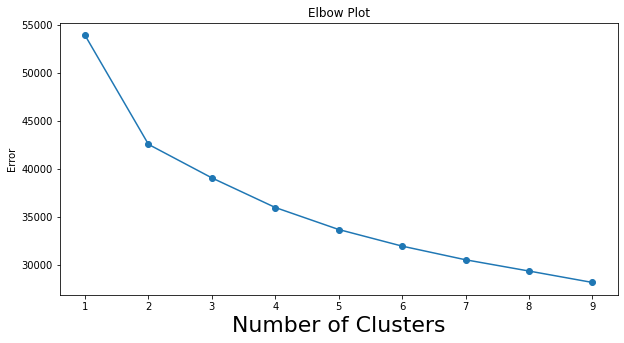

In [6]:
wss = []
kmeans = []
cluster_range = range(1,10)

for num_cluster in cluster_range:
    kmean_cluster = KMeans(num_cluster,n_init = 10)
    kmean_cluster.fit(scaled_df)
    
    wss.append(kmean_cluster.inertia_)
    kmeans.append(kmean_cluster)

plt.figure(figsize=(10,5))
plt.plot(cluster_range, wss, marker = "o" )
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters', fontsize=22)
plt.ylabel('Error')
plt.xticks(cluster_range)
plt.show()

## 3-2) Number of Clusters through silhouette_scores

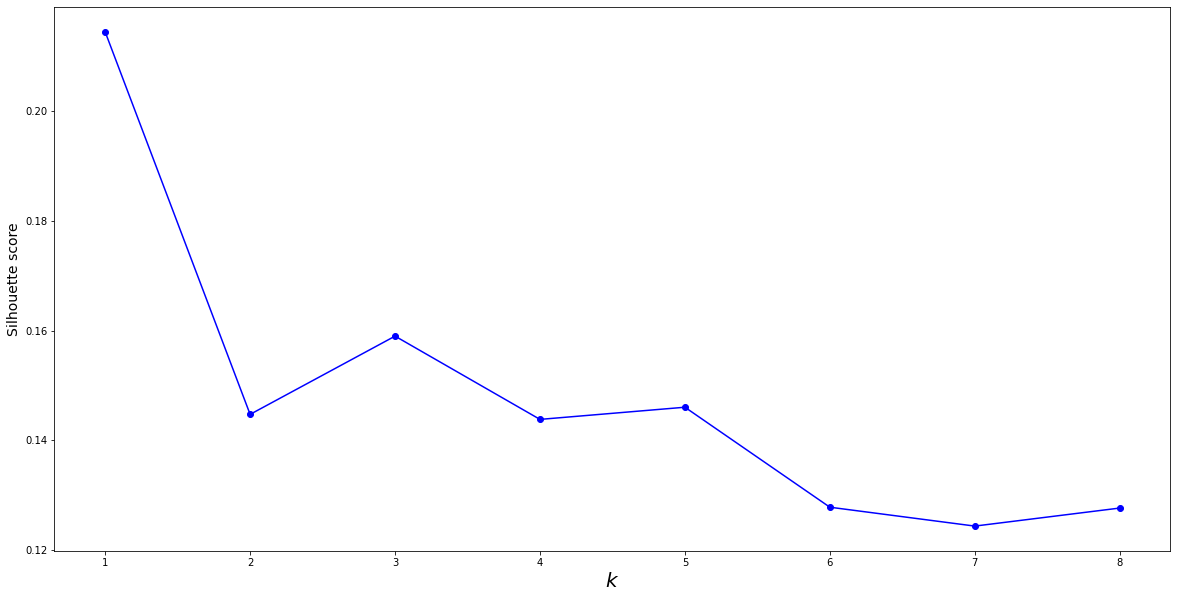

In [8]:
silhouette_scores =[]
for model in kmeans[1:]:#ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
    s=silhouette_score(scaled_df, model.labels_,metric='euclidean')
    silhouette_scores.append(s)
    
plt.figure(figsize=(20, 10))
plt.plot(range(1, 9),silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=20)
plt.ylabel("Silhouette score", fontsize=14)

plt.show()

Based on two graphs above, we consider k=3.

In [30]:
# Instantiate a K-Means model with K= 3
# Fitting the model and making initial predictions to visualize
kmeans = KMeans(n_clusters = 3, init = 'k-means++')
kmeans.fit(scaled_df)


predictions = kmeans.fit_predict(scaled_df)
print(predictions)


[0 1 2 ... 2 1 1]


What is inertia_? Inertia is defined as the sum of squared distances of data points to their closest cluster center (centroid). Lower the distance better the compactness of the clusters. However, inertia decreases as we keep increasing the value of K. An algorithm with two clusters will always have a higher inertia score than the one with four clusters and so on. This is where we combine elbow plot and silhouette score to decide the optimum value of K.

# 3-3) Mapping the Disribution of each Clusters

In [31]:
X = scaled_df.iloc[:,:-1]
y = scaled_df.iloc[:,-1]
y
X_dist = kmeans.transform(scaled_df)**2
y = kmeans.predict(scaled_df)
y

array([0, 1, 2, ..., 2, 1, 1], dtype=int32)

In [28]:
centroids=kmeans.cluster_centers_
scaled_df["category"]= kmeans.fit_predict(scaled_df)
centroids.shape

distances_0 = [cdist([center_elem],scaled_df.iloc[list(scaled_df[scaled_df["category"]==0].index)]) for center_elem in centroids][0]
distances_1 = [cdist([center_elem],scaled_df.iloc[list(scaled_df[scaled_df["category"]==1].index)]) for center_elem in centroids][0]
distances_2 = [cdist([center_elem],scaled_df.iloc[list(scaled_df[scaled_df["category"]==2].index)]) for center_elem in centroids][0]


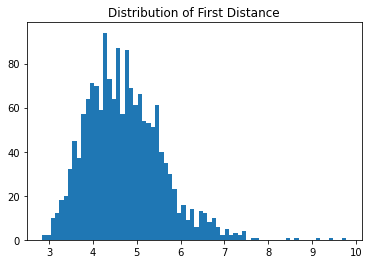

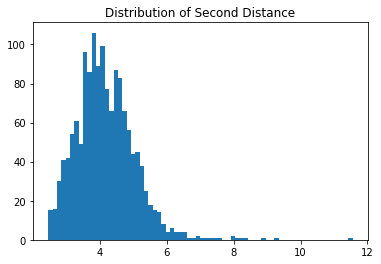

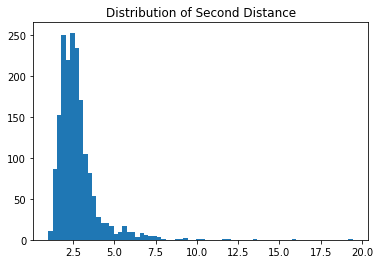

In [27]:
plt.hist(np.ravel(distances_0),bins=70);
plt.title("Distribution of First Distance")
plt.show()

plt.hist(np.ravel(distances_1),bins=70);
plt.title("Distribution of Second Distance")
plt.show()

plt.hist(np.ravel(distances_2),bins=70);
plt.title("Distribution of Second Distance")
plt.show()

# 4 Determine the Most Important Features

### 4-1) Extract top 10 best features Through SelectKBest class and ExtraTreesClassifier

[0.14131708 0.02360923 0.0383954  0.13116821 0.03645751 0.06555905
 0.08708749 0.14984397 0.15373901 0.04206725 0.1307558 ]


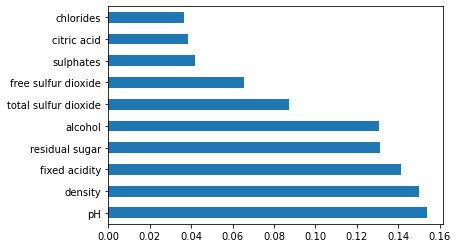

In [11]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [17]:
# Apply SelectKBest to Extract Best Features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(np.abs(X),y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(13,'Score'))  #print 10 best features

                   Specs       Score
7                density  167.139528
3         residual sugar  163.397461
0          fixed acidity   73.071140
2            citric acid   67.496009
6   total sulfur dioxide   62.899581
5    free sulfur dioxide   54.248018
8                     pH   42.526162
9              sulphates   41.959240
4              chlorides   32.286485
1       volatile acidity   22.394793
10               alcohol   10.386869


# 4-2) Determine the Best Fatures Through PCA

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,category
PC1,0.099657,0.008630,0.117226,0.410129,0.199507,0.300508,0.394182,0.483064,-0.082542,0.053996,-0.412834,-0.330223
PC2,-0.604667,0.050031,-0.343838,-0.041760,-0.040077,0.225057,0.158430,-0.069481,0.574797,0.199051,0.034944,-0.241842
PC3,0.115950,-0.589422,0.499404,-0.213058,-0.101230,0.285374,0.130981,-0.126580,0.133550,0.436937,0.102939,0.011350
PC4,0.018117,0.278254,0.145397,-0.273446,0.710117,-0.300925,-0.054773,-0.021061,0.099850,0.444997,-0.141440,0.008356
PC5,0.244437,0.642085,0.040640,0.011103,-0.324880,0.195510,0.309950,-0.081342,-0.112159,0.396526,0.330046,0.031654
PC6,-0.108572,0.112991,0.124226,-0.288648,0.400325,0.497348,0.278620,-0.323119,-0.187239,-0.484558,0.130262,0.014882


[7, 0, 1, 4, 1, 5]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['density', 'fixed acidity', 'volatile acidity', 'chlorides', 'volatile acidity', 'free sulfur dioxide']

{'PC1': 'density', 'PC2': 'fixed acidity', 'PC3': 'volatile acidity', 'PC4': 'chlorides', 'PC5': 'volatile acidity', 'PC6': 'free sulfur dioxide'}


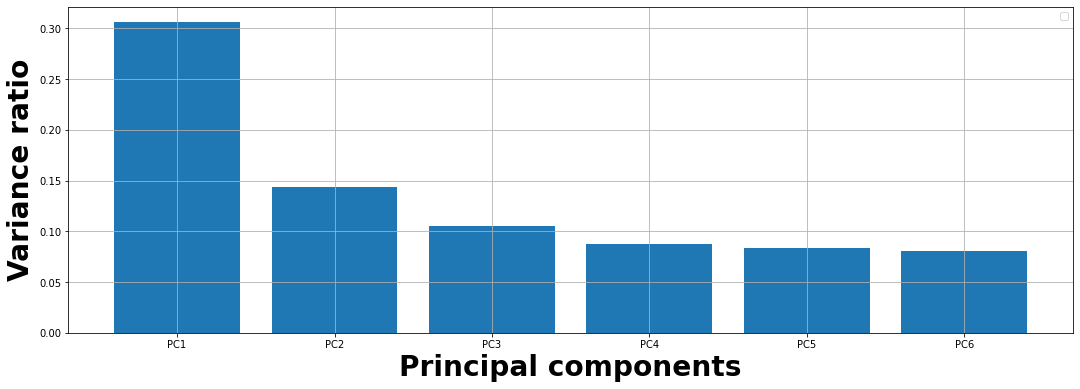

,PC1,PC2,PC3,PC4,PC5,PC6
0,3.749457,-0.823219,-0.930907,-1.137238,-0.294309,-0.885078
1,-0.599240,0.500657,-0.353870,0.995501,-0.721621,-0.473909
2,-0.290061,-1.423736,-0.020442,0.269959,-0.363409,-0.489746


In [23]:

pca2 = PCA(n_components=6).fit(scaled_df)

loadings = pca2.components_##we have 6 components
n_pcs= pca2.components_.shape[0]
pc_list=["PC{}".format(i+1) for i in range(n_pcs)]

pca_original_data = pd.DataFrame(loadings,columns=list(scaled_df.columns),index=pc_list)
display(pca_original_data)

most_important = [np.abs(pca2.components_[i]).argmax() for i in range(n_pcs)]
display(most_important)

most_important_names = [list(scaled_df.columns)[most_important[i]] for i in range(n_pcs)]
print(most_important_names, end="")


print("\n")
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
print(dic)


columns=pc_list
# Plot the explained variances
plt.figure(figsize=(18, 6))
plt.bar(x=range(pca2.n_components_),height=pca2.explained_variance_ratio_,tick_label=columns)
plt.legend()
plt.grid(True)
plt.ylabel('Variance ratio',fontweight="bold",fontsize=28)
plt.xlabel('Principal components',fontweight="bold",fontsize=28)
plt.xticks(range(pca2.n_components_))
plt.show()

principalComponents = pca2.fit_transform(scaled_df)
# Save the componenets of pca(eigen values) to a dataframe
PCA_components = pd.DataFrame(data=principalComponents, columns=columns)
display(PCA_components.head(3))


In [64]:
pca_original_data.T.sort_values(by=["PC1"], ascending=False)

,PC1,PC2,PC3,PC4,PC5,PC6
density,0.473304,0.057188,-0.112468,0.004673,-0.089899,0.339204
residual sugar,0.401503,0.042162,-0.205346,-0.252174,0.004664,0.305489
category,0.369466,-0.135441,-0.047178,-0.053821,0.007462,-0.039334
total sulfur dioxide,0.367168,0.281275,0.125248,-0.064751,0.293922,-0.266920
free sulfur dioxide,0.269731,0.313133,0.269888,-0.322665,0.178551,-0.484968
chlorides,0.195487,0.015368,-0.089521,0.708479,-0.319456,-0.414189
fixed acidity,0.166504,-0.557279,0.146596,0.037784,0.247787,0.118291
citric acid,0.142162,-0.312886,0.520118,0.149078,0.055569,-0.130756
sulphates,0.023242,0.240029,0.433211,0.435776,0.402366,0.462672
volatile acidity,0.006456,0.040803,-0.588763,0.275082,0.644951,-0.118398


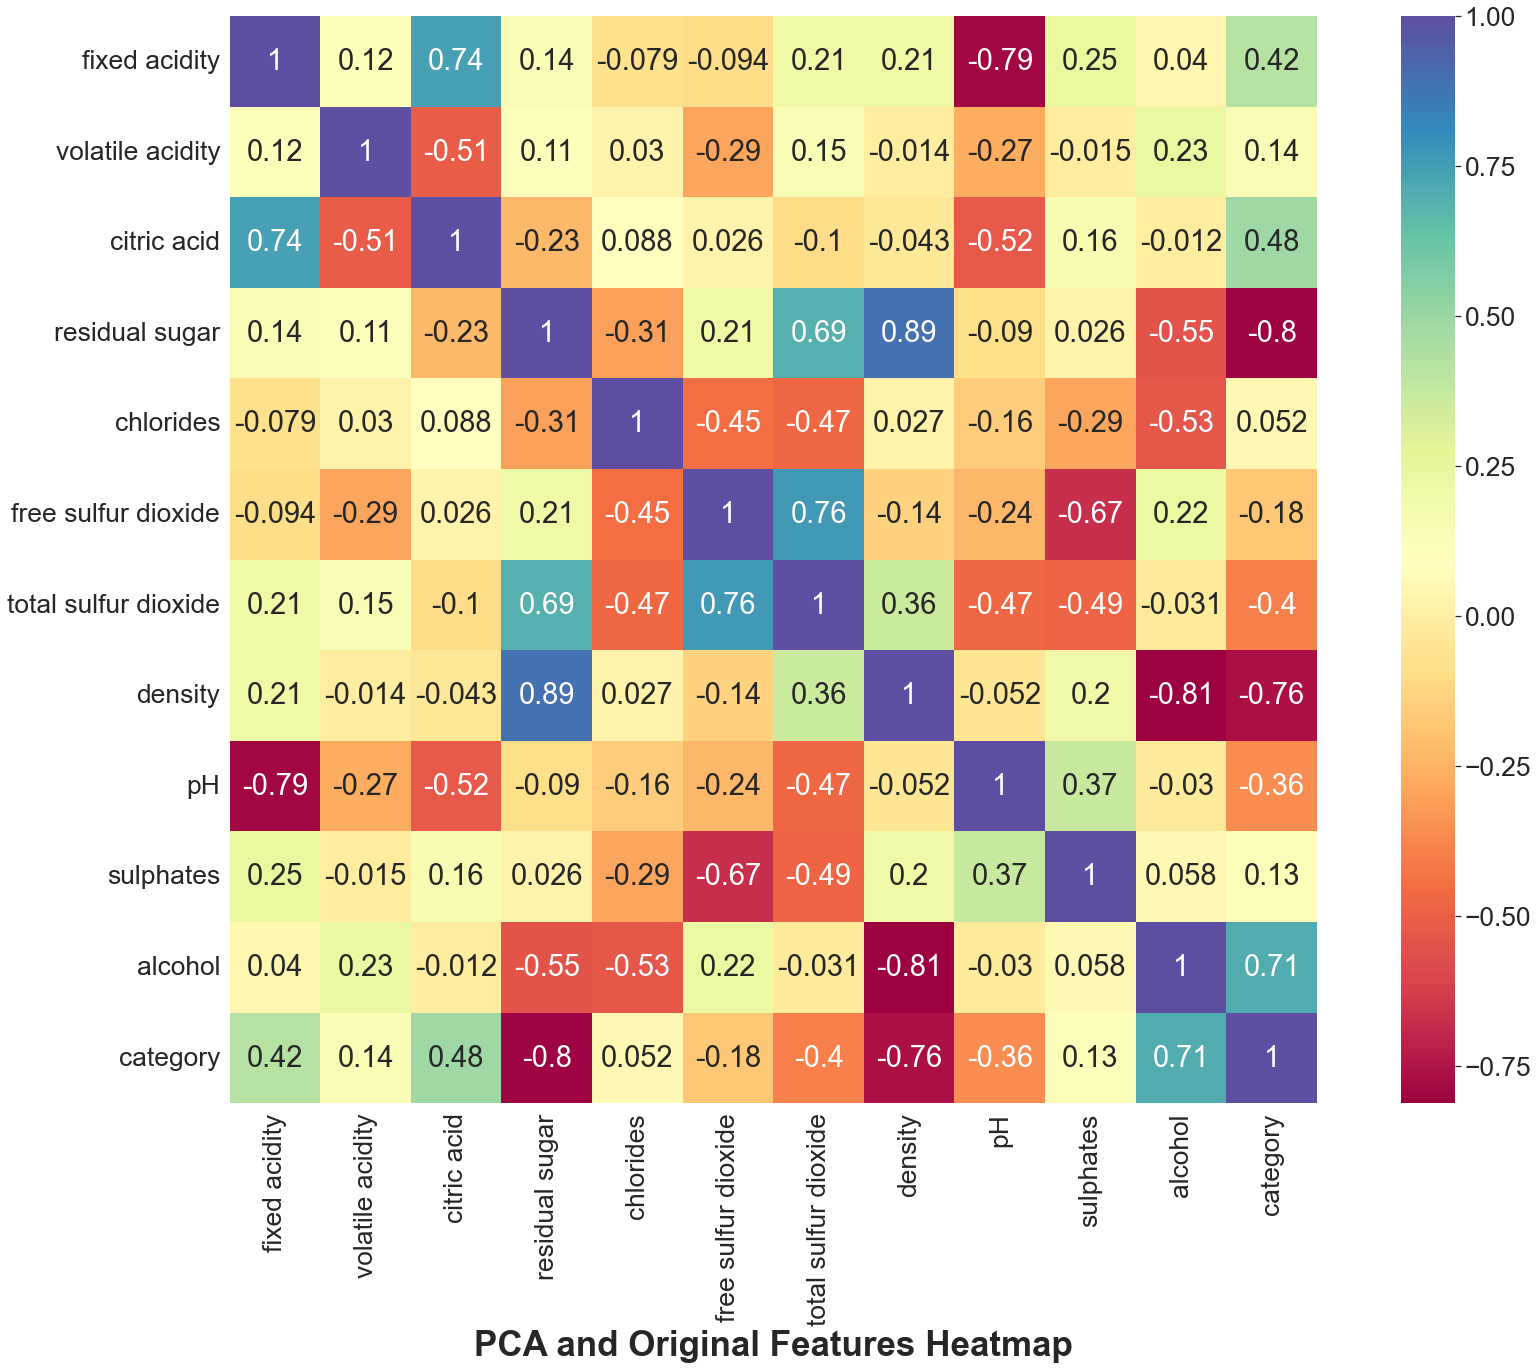

In [59]:
corr = pca_original_data.corr()
plt.figure(figsize=(30,20))
sns.set(font_scale=2.4)
sns.heatmap(corr, annot=True, cmap="Spectral", vmax=1,annot_kws={"size": 29},square=True,linecolor="black")
plt.xlabel('PCA and Original Features Heatmap', fontsize=35, weight="bold");

## 4-3) Visualization of Kmeans Clusters, Considering the two first important features of PCA

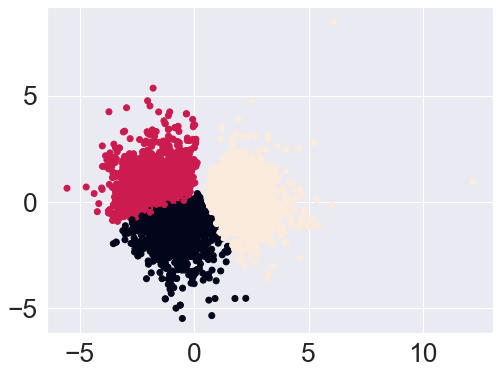

In [63]:
## Consider the first two features of PCA
pca = PCA(n_components = 6)
pca_less_features = pca.fit_transform(scaled_df)
pca_less_features

kmeans=KMeans(n_clusters=3,random_state=42)
cluster_labels = kmeans.fit_predict(pca_less_features)
kmean_labels = kmeans.labels_
kmean_labels

plt.figure(figsize=(8, 6))
plt.scatter(pca_less_features[:,0], pca_less_features[:,1], c=kmeans.labels_.astype(float))
plt.show()

# 5) Detect which Kmeans Cluster Mapped to the 2 Best Features Identified through PCA and Score

In [34]:
kms = KMeans(n_clusters=2).fit(scaled_df[["density", "residual sugar"]])
scaled_df_less = scaled_df[["density", "residual sugar"]]
scaled_df_less["cluster"] = kms.labels_
scaled_df_less

/var/folders/53/xb6mvrb12jz8s_klw8m0dwbm0000gn/T/ipykernel_83572/1533425456.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_df_less["cluster"] = kms.labels_


,density,residual sugar,cluster
0,2.331512,2.821349,1
1,-0.009154,-0.944765,0
2,0.358665,0.100282,1
3,0.525855,0.415768,1
4,0.525855,0.415768,1
...,...,...,...
4893,-0.965483,-0.944765,0
4894,0.291789,0.317179,1
4895,-0.497350,-1.023637,0
4896,-1.784717,-1.043355,0


In [35]:
y_kmeans = kms.fit_predict(scaled_df_less)

X_dist_new = kms.transform(scaled_df_less)**2
X_dist_new 

center_dists_new = pd.DataFrame(np.array([X_dist_new[i][x] for i,x in enumerate(y_kmeans)]),columns = ["min_distance"])
center_dists_new

max_indices_ = []

for label in np.unique(kms.labels_):
#     print(label)
    X_label_indices = np.where(y_kmeans==label)[0]
#     print(X_label_indices)
    max_label_idx_ = X_label_indices[np.argmax(center_dists_new[y_kmeans==label])]
    max_indices_.append(max_label_idx_)
    
max_indices_

[2945, 2781]

# 6) KMeans for Anomaly Detection

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


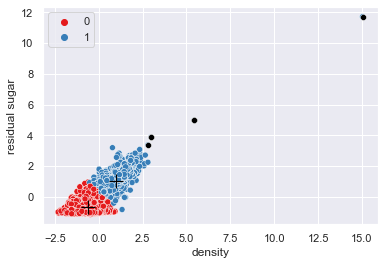

In [36]:
df = scaled_df_less.iloc[:,:-1].copy()
#From Zscore methods
z_score=[]
for i,j in enumerate(list(df.columns)):
    df["zscore"] = df.iloc[:,i]-df.iloc[:,i].mean()/df.iloc[:,i].std()
    

outlier = df[np.abs(df["zscore"])>3.2]
outlier_index = outlier["zscore"].index


sns.scatterplot(scaled_df_less.iloc[:,0], scaled_df_less.iloc[:,1], hue=y_kmeans, 
                palette=sns.color_palette("Set1", n_colors=2));

sns.scatterplot(kms.cluster_centers_[:,0], kms.cluster_centers_[:,1], 
                marker='+', 
                color='black', 
                s=200);

sns.scatterplot(scaled_df_less.iloc[outlier_index, 0], scaled_df_less.iloc[outlier_index, 1], color='black');

In [52]:
Dist_to_Clust = pd.DataFrame(kmeans.transform(scaled_df), columns = ["Distance_1", "Distance_2", "Distance_3"])
Dist_to_Clust

,Distance_1,Distance_2,Distance_3
0,2.661750,5.997511,5.182025
1,3.837305,1.997693,2.753946
2,3.017821,3.191289,2.009413
3,1.409732,3.813303,3.086232
4,1.409732,3.813303,3.086232
...,...,...,...
4893,4.627425,1.202265,2.456363
4894,1.361725,3.595211,3.146174
4895,3.780636,2.988157,2.387771
4896,5.960010,2.578441,3.791797


In [53]:
# Calculate the Anomaly score - as the minimum distance of a point to any cluster center
anomaly_score = Dist_to_Clust.min(axis = 1)
anomaly_score

0       2.661750
1       1.997693
2       2.009413
3       1.409732
4       1.409732
          ...   
4893    1.202265
4894    1.361725
4895    2.387771
4896    2.578441
4897    2.624522
Length: 4898, dtype: float64

In the above diagram, Distance_1 measures the distance of each point from Cluster Center #1. Distance_1 measures the distance of each point from Cluster Center #2 and Distance_3 measures the distance of each point from Cluster Center #3. As we can see, we have some isolated points in the top right corner. As we will discuss later, points like this may be considered as outliers.

Here is how we calculate the Anomaly score:

Calculate the cluster centers using k-Means.
Calculate the distance of each point from each cluster center using the transform method of cluster.KMeans() object.
Take the minimum of these distances for each point i.e. we calculate the distance of each point from its closest cluster center. This distance is the anomaly score of the points. A larger anomaly score means the point is more anomalous. It is also possible to treat the average distance of each point from each cluster as the anomaly score.

As we see, the black points are the most anomalous — as correctly identified by this method. The black points above are detected as anomalous as they have a higher anomaly score. This method, like many other methods, transforms data into new space and uses this representation to tag points as anomalous.

# 7) DBSCAN for Anomaly Detection

### 7-1) Finding the Best Parameters
As for this, we need to find out the parameters of DBSCAN that are min_samples and best_eps

In [37]:
# import plotly.express as px
X=scaled_df_less.iloc[:,:-1].values
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distance_desc = sorted(distances[:,-1], reverse=True)
# plt.plot(distance_desc)

[0.         0.00334381]


<Figure size 360x360 with 0 Axes>

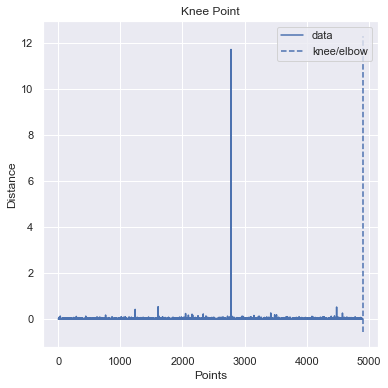

In [38]:
# parameter tuning for eps
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances[:,-1], S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance");
best_eps = distances[knee.knee];
print(best_eps);

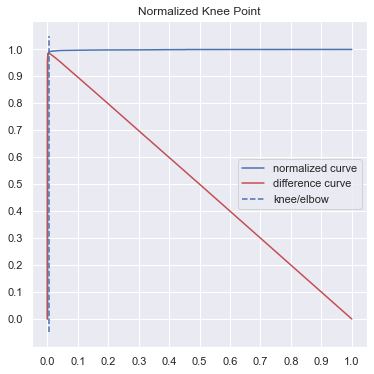

In [81]:

kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure
kneedle.plot_knee_normalized()

anom_index: 
 (array([   0,    1,    2, ..., 4895, 4896, 4897]),)


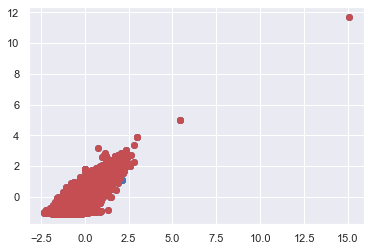

In [100]:
##Anomaly Detection with DBSCAN
dbscan = DBSCAN(eps = best_eps[1], min_samples = 4)
# print(dbscan) 
## Fitting the Dbscan and find the index and values of anomalies
pred = dbscan.fit_predict(X)
anom_index = np.where(pred == -1)##it can be with or without the numpy
##or 
# x[dbscan.labels_==-1]
print("anom_index: \n", anom_index)
anom_values = scaled_df_less.iloc[anom_index[0],:-1]
# print("anom_values: \n", anom_values)
##Plot the DBSCAN with anomalies
plt.scatter(X[:,0], X[:,1])
plt.scatter(anom_values.iloc[:,0], anom_values.iloc[:,1], color="r")
plt.show()

As can be seen, DBSCAN cannot detect the anomaly so we use HDBSCAN as follows

# Anomaly Through HDBSCAN

In [44]:

def get_hdbscan(data, min_cluster_size):
	hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, gen_min_span_tree=True)
	vals = data.iloc[ :, 0:].values
	y_pred = hdb.fit_predict(StandardScaler().fit_transform(vals))
	data["cluster"] = y_pred
	return data, hdb

hdbsca, clusterer = get_hdbscan(scaled_df_less,min_cluster_size=10)
hdbsca

,density,residual sugar,cluster
0,2.331512,2.821349,1
1,-0.009154,-0.944765,0
2,0.358665,0.100282,1
3,0.525855,0.415768,1
4,0.525855,0.415768,1
...,...,...,...
4893,-0.965483,-0.944765,0
4894,0.291789,0.317179,1
4895,-0.497350,-1.023637,0
4896,-1.784717,-1.043355,0


In [45]:
# specify parameters and distributions to sample from

hdb = hdbscan.HDBSCAN(gen_min_span_tree=True).fit(scaled_df_less)
param_dist = {'min_samples': [10,30,50,60,100],
              'min_cluster_size':[100,200,300,400,500,600],  
              'cluster_selection_method' : ['eom','leaf'],
              'metric' : ['euclidean','manhattan'] 
             }

#validity_scroer = "hdbscan__hdbscan___HDBSCAN__validity_index"
validity_scorer = make_scorer(hdbscan.validity.validity_index,greater_is_better=True)

In [46]:
n_iter_search = 20
random_search = RandomizedSearchCV(hdb
                                   ,param_distributions=param_dist
                                   ,n_iter=n_iter_search
                                   ,scoring=validity_scorer 
                                   ,random_state=1)

random_search.fit(scaled_df_less.iloc[:,:-1])


print(f"Best Parameters {random_search.best_params_}")
print(f"DBCV score :{random_search.best_estimator_.relative_validity_}")

# evalute the clusters
labels = random_search.best_estimator_.labels_
clustered = (labels >= 0)
    
coverage = np.sum(clustered) / scaled_df_less.shape[0]
total_clusters = np.max(labels) + 1
cluster_sizes = np.bincount(labels[clustered]).tolist()

print(f"Percent of data retained: {coverage}")
print(f"Total Clusters found: {total_clusters}")
print(f"Cluster splits: {cluster_sizes}")

Best Parameters {'min_samples': 10, 'min_cluster_size': 200, 'metric': 'manhattan', 'cluster_selection_method': 'leaf'}
DBCV score :0.5404450544699463
Percent of data retained: 0.6690485912617394
Total Clusters found: 4
Cluster splits: [2090, 563, 402, 222]


<AxesSubplot:ylabel='$\\lambda$ value'>

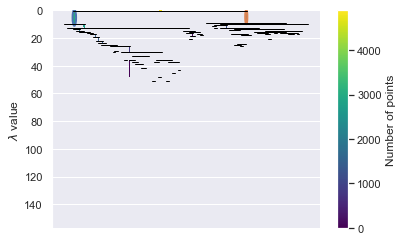

In [47]:
random_search.best_params_
min_samples=random_search.best_params_["min_samples"]
min_cluster_size=random_search.best_params_["min_cluster_size"]
metric=random_search.best_params_["metric"]
cluster_selection_method=random_search.best_params_["cluster_selection_method"]
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [49]:
hdbscan_= hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,
                            metric=metric,cluster_selection_method=cluster_selection_method)

y_hdb = hdbscan_.fit_predict(scaled_df_less.iloc[:,:-1])
print(np.unique(hdbscan_.labels_))
np.unique(y_hdb)
df_hdb = pd.DataFrame(scaled_df_less.iloc[:,:-1])
df_hdb

df_hdb['HDBSCAN_labels']=y_hdb
df_hdb['HDBSCAN_labels'].value_counts()

[-1  0  1  2  3]


 0    2090
-1    1621
 1     563
 2     402
 3     222
Name: HDBSCAN_labels, dtype: int64

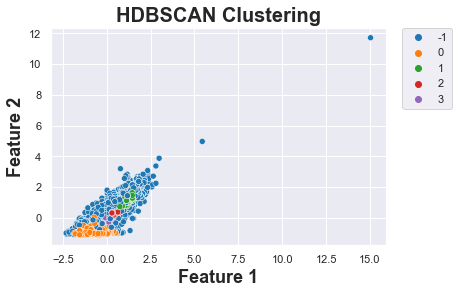

In [50]:
# plt.figure(figsize=(10,10))
sns.scatterplot(df_hdb.iloc[:,0],df_hdb.iloc[:,1],hue=df_hdb['HDBSCAN_labels'],palette="tab10")
# sns.color_palette("tab10")

plt.title('HDBSCAN Clustering',fontsize=20,weight='bold')
plt.xlabel('Feature 1',fontsize=18,weight='bold')
plt.ylabel('Feature 2',fontsize=18,weight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True,
           borderaxespad=0);

As can be seen from the above, the KMeans is the best method of detecting the noise and anomaly in this case. But, DBSCAN and HDBSCAN are used when the anomalies are based on densities.